In [4]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,precision_recall_curve, average_precision_score,roc_curve, auc
import scikitplot as skplt

spark = SparkSession.builder.appName("feature").getOrCreate()

# Load the data stored in LIBSVM format as a DataFrame.
data = spark.read.format("libsvm").load("../spark/data/mllib/iris_libsvm.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
data = labelIndexer.transform(data)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)
data = featureIndexer.transform(data)

# Split the data into training and test sets (30% held out for testing)
(train, test) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Train model.  This also runs the indexers.
model = dt.fit(train)

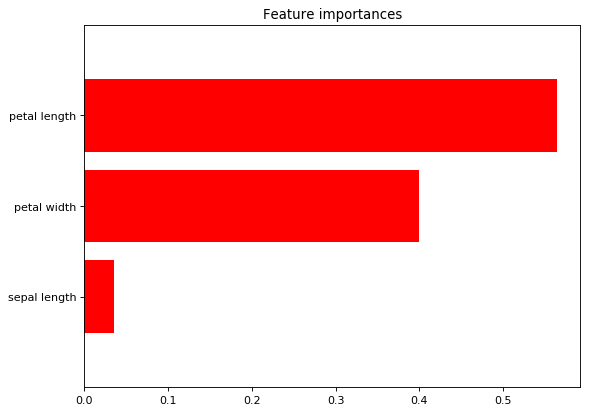

In [5]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
importances = model.featureImportances.values
cols = model.featureImportances.indices
indices = np.argsort(importances)

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],color="r")
plt.yticks(range(len(indices)), [features[i] for i in cols[indices]])
plt.ylim([-1, importances.shape[0]])
plt.show()

In [7]:
test_eval = model.transform(test)
test_eval = test_eval.select('indexedLabel','prediction', 'rawPrediction','probability')

In [11]:
result = test_eval.select('indexedLabel', 'probability', 'prediction').toPandas()

In [12]:
def vec2array(df):
    series = df.apply(lambda x : np.array(x.toArray())).values.reshape(-1,1)
    return np.apply_along_axis(lambda x : x[0], 1, series)

In [13]:
prob = vec2array(result['probability'])

In [14]:
print(classification_report(result['indexedLabel'], result['prediction']))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        10
        1.0       1.00      1.00      1.00        13
        2.0       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00        38



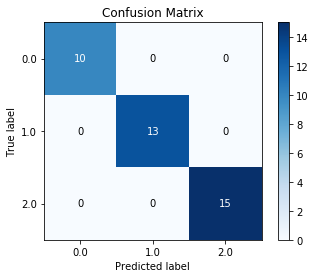

In [15]:
skplt.metrics.plot_confusion_matrix(result['indexedLabel'], result['prediction'])

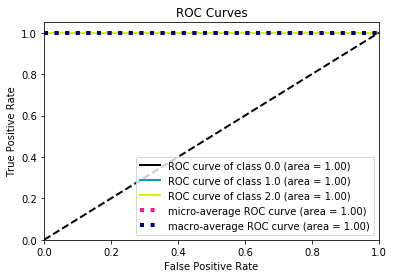

In [16]:
skplt.metrics.plot_roc(result['indexedLabel'], prob)

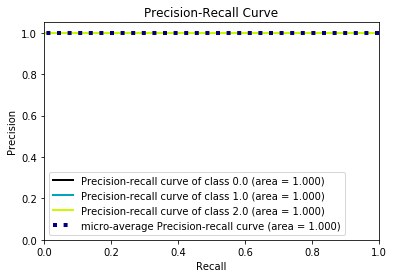

In [17]:
skplt.metrics.plot_precision_recall(result['indexedLabel'], prob)